## Import Packages

In [1]:
from datetime import date
import logging
import numpy as np
import os
import pandas as pd
import sys
import swifter
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, roc_auc_score, auc, roc_curve, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import warnings


from src.local.etl_helper import Extract
from src.local.feature_engineering_helper import MutualInformation
from src.local.preprocess_helper import CreateTargetLabel, ColumnPreprocess


sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore')

Settings for jupyter notebook

In [2]:
# !jupyter contrib nbextension install --user
# !jupyter nbextension enable toc2/main

## Read Data

Description for each column

In [3]:
# big5 encoding to avoid unidecodeerror
path = '/home/js/py_ds_nas/ds_competitions/kaggle/using-coupon-prediction/data'
column_description = pd.read_csv(os.path.join(path, 'column_description.csv'), encoding = "big5")
column_description

,Column,Description
0,User_id,用戶 ID
1,Merchant_id,商家 ID
2,Coupon_id,優惠券 ID (null 代表無優惠券消費)
3,Discount_rate,"優惠券折價：[0,1] 代表折扣率；x:y 代表滿 x 減 y 元"
4,Distance,"用戶經常活動地點離商家最近距離 (x * 500 公尺), 0 表示低於 500 公尺, 1..."
5,Date_received,優惠券取得時間
6,Date,購買商品時間 (如果 Date is null & Coupon_id is not nul...


[2021-05-20 00:53:04,748] - p15171 - {/home/js/py_ds_nas/ds_competitions/kaggle/using-coupon-prediction/src/local/etl_helper.py:28} - extract - INFO - shape: (1160742, 7)
[2021-05-20 00:53:04,750] - p15171 - {/home/js/py_ds_nas/ds_competitions/kaggle/using-coupon-prediction/src/local/etl_helper.py:29} - extract - INFO - columns: Index(['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance',
       'Date_received', 'Date'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1160742 entries, 0 to 1160741
Data columns (total 7 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   User_id        1160742 non-null  int64  
 1   Merchant_id    1160742 non-null  int64  
 2   Coupon_id      746969 non-null   float64
 3   Discount_rate  746969 non-null   object 
 4   Distance       1090916 non-null  float64
 5   Date_received  746969 non-null   float64
 6   Date           456709 non-null   float64
dtypes: float

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN


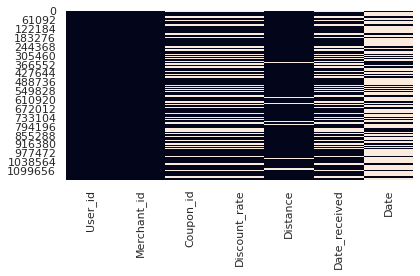

In [4]:
df_train = Extract().read(
    '/home/js/py_ds_nas/ds_competitions/kaggle/using-coupon-prediction/data/train_offline.csv')
df_train.head(3)

[2021-05-20 00:53:15,343] - p15171 - {/home/js/py_ds_nas/ds_competitions/kaggle/using-coupon-prediction/src/local/etl_helper.py:28} - extract - INFO - shape: (594142, 9)
[2021-05-20 00:53:15,345] - p15171 - {/home/js/py_ds_nas/ds_competitions/kaggle/using-coupon-prediction/src/local/etl_helper.py:29} - extract - INFO - columns: Index(['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance',
       'Date_received', 'Date', 'label', 'to_testset'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594142 entries, 0 to 594141
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   User_id        594142 non-null  int64  
 1   Merchant_id    594142 non-null  int64  
 2   Coupon_id      306313 non-null  float64
 3   Discount_rate  306313 non-null  object 
 4   Distance       557965 non-null  float64
 5   Date_received  306313 non-null  float64
 6   Date           320275 non-null  float64
 7

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,label,to_testset
0,1439408,4663,11002.0,150:20,1.0,20160528.0,NaN,0,True
1,1439408,2632,8591.0,20:1,0.0,20160613.0,NaN,0,True
2,1439408,2632,NaN,NaN,0.0,NaN,20160516.0,-1,True


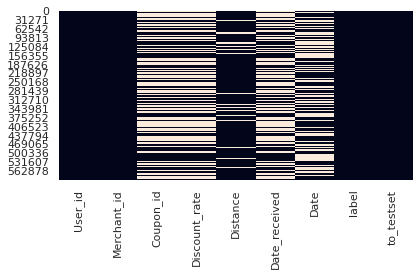

In [5]:
df_test = Extract().read(
    '/home/js/py_ds_nas/ds_competitions/kaggle/using-coupon-prediction/data/test_offline.csv')
df_test.head(3)

## Preprocessing - Basic preprocess for each column

In [6]:
df_train["label"] = df_train.swifter.apply(CreateTargetLabel.label, axis=1)
df_train["label"].value_counts()

 0    710665
-1    413773
 1     36304
Name: label, dtype: int64

In [7]:
df_train.shape

(1160742, 8)

In [8]:
df_train = ColumnPreprocess().process_data(df=df_train)
df_test = ColumnPreprocess().process_data(df=df_test)

Pandas Apply:   0%|          | 0/1160742 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1160742 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1160742 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1160742 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1160742 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/594142 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/594142 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/594142 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/594142 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/594142 [00:00<?, ?it/s]

## EDA

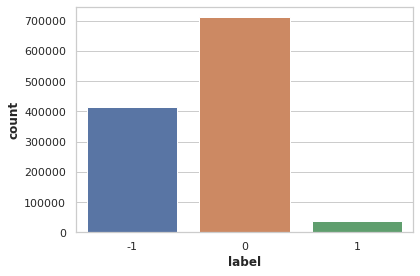

In [9]:
ax = sns.countplot(x="label", data=df_train)

This is an imbalanced dataset

Mutual Information (MI)

MI score - value meaning

--

infinity

2: above is unusual

0: independent

In [11]:
X = df_train.dropna(how='any')
X = X.loc[:, ~X.columns.isin(['Date', 'Discount_rate', 'Date_received'])]
y = X.pop('label')

mi_scores = MutualInformation().make_mi_scores(X, y)
print('mi_scores:', mi_scores)

mi_scores: User_id          4.440225
Coupon_id        0.599750
Merchant_id      0.430143
discount_jian    0.035499
discount_man     0.028577
discount_rate    0.023015
discount_type    0.018728
weekday_5        0.008849
is_weekend       0.008571
weekday_3        0.008398
weekday_2        0.006575
weekday_6        0.006331
weekday_7        0.006249
weekday_1        0.005931
weekday_4        0.005667
Distance         0.002680
weekday          0.001203
Name: MI Scores, dtype: float64
